# Lancaster County Incident Timelines

This notebook explores the temporal patterns in `lancaster_incidents.json`, focusing on when incidents are created/updated and identifying the times of day with the most activity.


In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
pd.options.display.float_format = "{:.2f}".format


In [2]:
data_path = Path('../../resources/original_incident_records/lancaster_incidents_filtered_labeled.json')
print(f"Loading {data_path}")

with open(data_path, 'r', encoding='utf-8') as f:
    incidents = json.load(f)

print(f"Total incidents loaded: {len(incidents):,}")


Loading ..\..\resources\original_incident_records\lancaster_incidents_filtered_labeled.json
Total incidents loaded: 146,109


In [3]:
df = pd.DataFrame(incidents)
print(f"Columns available: {sorted(df.columns.tolist())}")


def _extract_date(value):
    return value.get('$date') if isinstance(value, dict) else value


def parse_timestamp_series(series: pd.Series) -> pd.Series:
    # Pull nested $date values if present and standardize empty strings to NA
    base = series.map(_extract_date).replace('', pd.NA)

    # First attempt: treat everything as epoch-milliseconds when numeric
    numeric = pd.to_numeric(base, errors='coerce')
    parsed = pd.to_datetime(numeric, unit='ms', utc=True, errors='coerce')

    # Second attempt: parse the remaining strings (ISO 8601, RFC 1123, etc.)
    string_mask = parsed.isna() & base.notna()
    if string_mask.any():
        parsed.loc[string_mask] = pd.to_datetime(base[string_mask], utc=True, errors='coerce')

    return parsed.dt.tz_convert('America/New_York')


# Parse timestamps using the vectorized helper
if '_created_at' in df.columns:
    df['created_at'] = parse_timestamp_series(df['_created_at'])
else:
    df['created_at'] = pd.NaT

if '_updated_at' in df.columns:
    df['updated_at'] = parse_timestamp_series(df['_updated_at'])
else:
    df['updated_at'] = pd.NaT

# Parse the human-readable incident time string (e.g., "Tue, 05 Aug 2025 15:43:57 GMT")
df['incident_dt'] = pd.to_datetime(df['incidentTime'], utc=True, errors='coerce').dt.tz_convert('America/New_York')

summary = df[['created_at', 'updated_at', 'incident_dt']]
print("\nTimestamp coverage:")
print(summary.agg(['count', 'min', 'max']).T)


Columns available: ['_created_at', '_id', '_updated_at', 'active', 'county', 'crossStreet', 'description', 'geoLocation', 'growth_zone_municipality', 'growth_zone_name', 'growth_zone_source', 'growth_zone_type', 'incidentID', 'incidentTime', 'incidentTime_timezone', 'incidentType', 'latitude', 'longitude', 'municipalID', 'municipality', 'numberOfUnits', 'pushSent', 'state', 'street', 'type', 'unitsInactive', 'unitsString']

Timestamp coverage:
              count                               min  \
created_at   146035  2023-01-16 13:09:53.735000-05:00   
updated_at   146026  2023-01-16 13:40:01.966000-05:00   
incident_dt  103472         2023-03-12 03:29:46-04:00   

                                          max  
created_at   2025-09-19 13:03:47.047000-04:00  
updated_at   2025-09-19 13:12:13.173000-04:00  
incident_dt         2025-09-19 09:01:37-04:00  


C:\Users\vsita_ru1\AppData\Local\Temp\ipykernel_20416\436208114.py:37: FutureWarning: Parsed string "Tue, 05 Aug 2025 11:43:57 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['incident_dt'] = pd.to_datetime(df['incidentTime'], utc=True, errors='coerce').dt.tz_convert('America/New_York')


In [4]:
created_daily = (
    df.loc[df['created_at'].notna()]
      .set_index('created_at')
      .resample('D')
      .size()
      .rename('Created')
)

updated_daily = (
    df.loc[df['updated_at'].notna()]
      .set_index('updated_at')
      .resample('D')
      .size()
      .rename('Updated')
)

timeline = pd.concat([created_daily, updated_daily], axis=1).fillna(0)
timeline_rolling = timeline.rolling(window=7, min_periods=1).mean()

timeline.tail()


,Created,Updated
2025-09-15 00:00:00-04:00,269,263
2025-09-16 00:00:00-04:00,218,226
2025-09-17 00:00:00-04:00,198,189
2025-09-18 00:00:00-04:00,226,232
2025-09-19 00:00:00-04:00,97,99


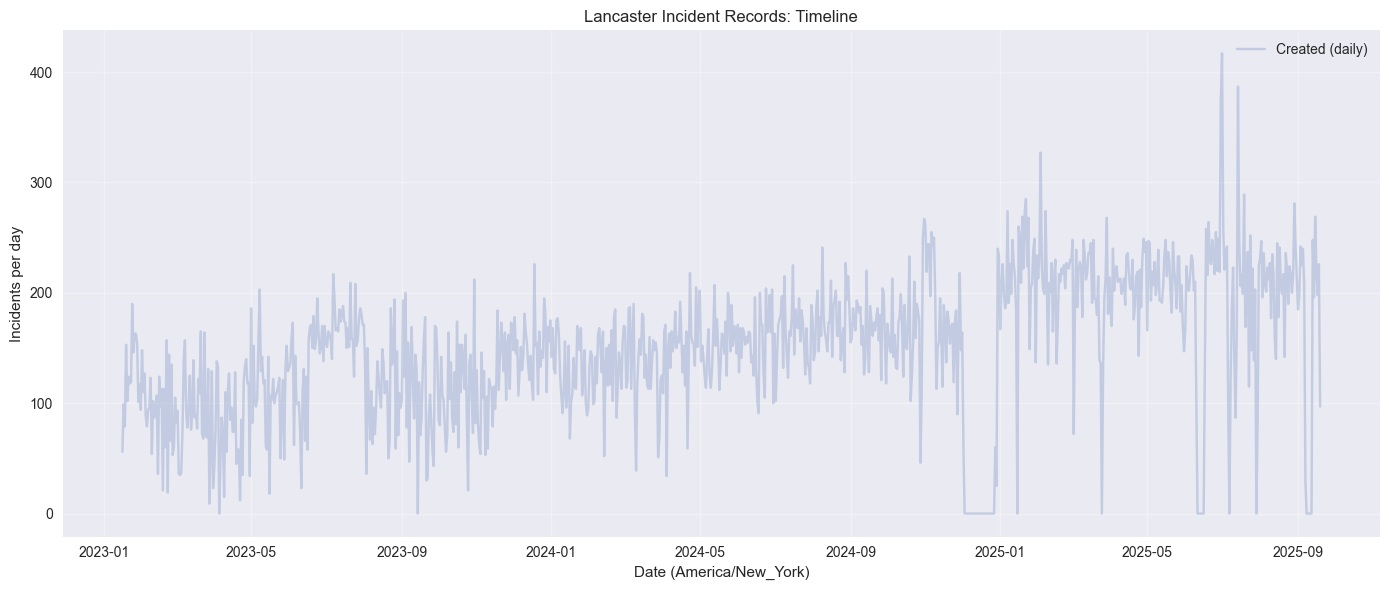

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(timeline.index, timeline['Created'], alpha=0.25, label='Created (daily)')
# ax.plot(timeline.index, timeline['Updated'], alpha=0.25, label='Updated (daily)')
# ax.plot(timeline_rolling.index, timeline_rolling['Created'], linewidth=2, label='Created (7-day mean)')
# ax.plot(timeline_rolling.index, timeline_rolling['Updated'], linewidth=2, label='Updated (7-day mean)')

ax.set_title('Lancaster Incident Records: Timeline')
ax.set_xlabel('Date (America/New_York)')
ax.set_ylabel('Incidents per day')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Most incidents occur during the 13:00 hour with 6,136 records.


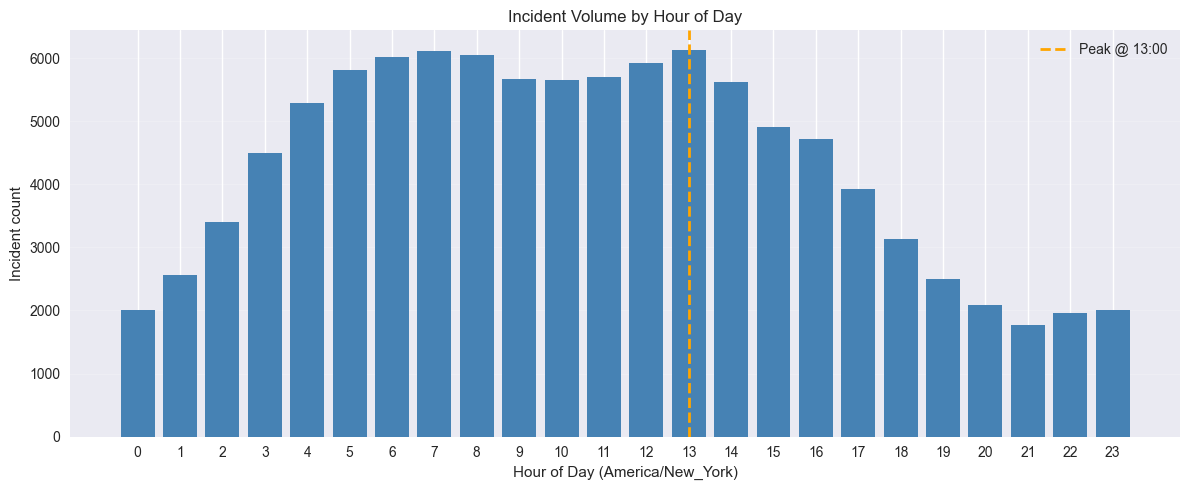

In [6]:
incident_hours = df['incident_dt'].dropna().dt.hour
hourly_counts = incident_hours.value_counts().sort_index()
peak_hour = int(hourly_counts.idxmax())
peak_count = int(hourly_counts.max())

print(f"Most incidents occur during the {peak_hour:02d}:00 hour with {peak_count:,} records.")

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(hourly_counts.index, hourly_counts.values, color='steelblue')
ax.axvline(peak_hour, color='orange', linestyle='--', linewidth=2, label=f'Peak @ {peak_hour:02d}:00')
ax.set_xticks(range(0, 24))
ax.set_xlabel('Hour of Day (America/New_York)')
ax.set_ylabel('Incident count')
ax.set_title('Incident Volume by Hour of Day')
ax.legend()
ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


## Incident Type (Description) Frequency


Most common description: MEDICAL EMERGENCY (106,805)
Least common description: TEST CALL-FIRE AND POLICE (1)


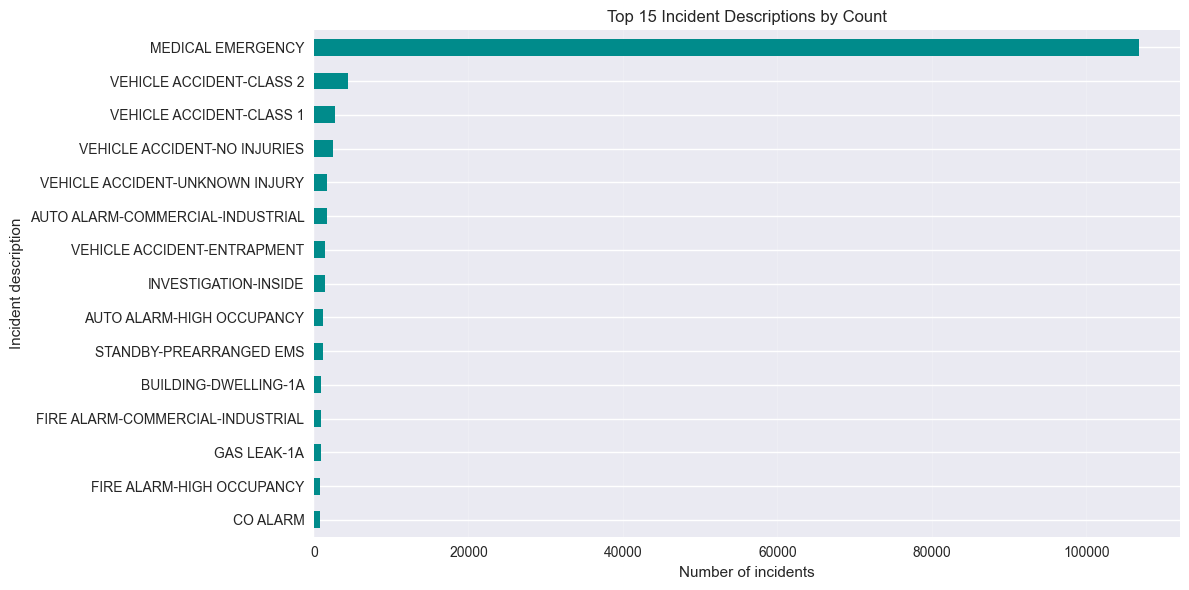

In [7]:
description_counts = (
    df['description']
      .fillna('Unknown')
      .astype(str)
      .str.strip()
)
description_counts = description_counts.replace('', 'Unknown').value_counts()

most_common_desc = description_counts.idxmax()
least_common_desc = description_counts.idxmin()

print(f"Most common description: {most_common_desc} ({description_counts.max():,})")
print(f"Least common description: {least_common_desc} ({description_counts.min():,})")

TOP_N = 15
fig, ax = plt.subplots(figsize=(12, 6))
(description_counts.head(TOP_N)
    .sort_values()
    .plot(kind='barh', color='darkcyan', ax=ax))

ax.set_title(f'Top {TOP_N} Incident Descriptions by Count')
ax.set_xlabel('Number of incidents')
ax.set_ylabel('Incident description')
ax.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()


## Top Descriptions within Each Incident Type


In [8]:
top_desc_per_type = (
    df.assign(
        incident_type=df['incidentType'].fillna('Unknown incident type').astype(str).str.strip(),
        cleaned_description=df['description'].fillna('Unknown description').astype(str).str.strip(),
    )
)

# Normalize any empty strings so Unknown buckets actually group together
for col, label in [('incident_type', 'Unknown incident type'), ('cleaned_description', 'Unknown description')]:
    top_desc_per_type[col] = top_desc_per_type[col].replace('', label)

incident_type_top20 = (
    top_desc_per_type
    .groupby(['incident_type', 'cleaned_description'])
    .size()
    .reset_index(name='count')
    .sort_values(['incident_type', 'count'], ascending=[True, False])
    .groupby('incident_type')
    .head(20)
    .rename(columns={'incident_type': 'Incident Type', 'cleaned_description': 'Description', 'count': 'Count'})
    .reset_index(drop=True)
)

incident_type_top20


,Incident Type,Description,Count
0,1,VEHICLE ACCIDENT-NO INJURIES,2445
1,1,MEDICAL EMERGENCY,838
2,1,TRAFFIC-HAZARD ON ROADWAY,702
3,1,TRAFFIC-DISABLED VEHICLE,625
4,1,VEHICLE ACCIDENT-HIT RUN-JUST OCC,380
5,1,VEHICLE ACCIDENT-CLASS 2,373
6,1,VEHICLE ACCIDENT-UNKNOWN INJURY,347
7,1,VEHICLE ACCIDENT-CLASS 1,273
8,1,TRAFFIC-SIGNAL MALFUNCTION,188
9,1,VEHICLE ACCIDENT-ENTRAPMENT,172


In [ ]:
# ranked_descriptions = (
#     incident_type_top5
#       .assign(Rank=lambda d: d.groupby('Incident Type').cumcount() + 1)
#       .sort_values(['Incident Type', 'Rank'])
# )

# summary_table = (
#     ranked_descriptions
#       .assign(Description_Count=lambda d: d['Description'] + ' (' + d['Count'].astype(int).astype(str) + ')')
#       .pivot(index='Incident Type', columns='Rank', values='Description_Count')
#       .rename(columns=lambda r: f'Top {r}')
#       .fillna('-')
#       .sort_index()
# )

# summary_table


NameError: name 'incident_type_top5' is not defined

## Base Station Activity


Unique base stations: 1490
unitsString
Units Assigned    6890
AMB 06-7          5370
MEDIC 82-1        4007
AMB 06-8          3116
MEDIC 06-3        3021
MEDIC 56-1        2989
AMB 06-1          2788
PENDING           2607
MEDIC 77-4        2560
AMB 01-1          2467
Name: count, dtype: int64


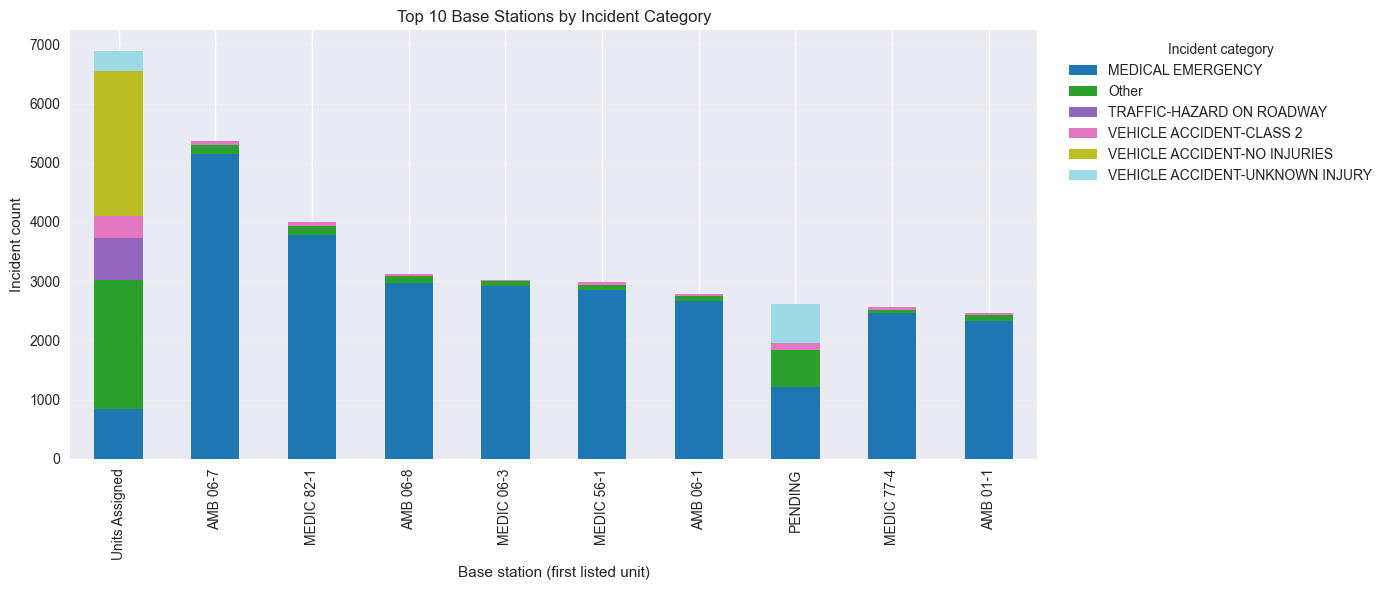

In [10]:
def extract_base_station(units_string: str) -> str:
    if not isinstance(units_string, str):
        return 'Unknown'
    first_unit = units_string.split(',')[0].strip()
    if ' - ' in first_unit:
        first_unit = first_unit.split(' - ')[0].strip()
    return first_unit or 'Unknown'

base_station_series = df['unitsString'].apply(extract_base_station)
df['base_station'] = base_station_series

base_station_counts = base_station_series.value_counts()
print(f"Unique base stations: {base_station_counts.shape[0]}")
print(base_station_counts.head(10))

# Focus on the busiest stations and the most common categories among them
TOP_STATIONS = 10
TOP_CATEGORIES = 5

desc_clean = (
    df['description']
      .fillna('Unknown')
      .astype(str)
      .str.strip()
      .replace('', 'Unknown')
)

top_stations = base_station_counts.head(TOP_STATIONS).index
subset = df[df['base_station'].isin(top_stations)].copy()
subset['incident_category'] = desc_clean.loc[subset.index]

# Collapse infrequent categories into "Other"
top_categories = (
    subset['incident_category']
      .value_counts()
      .head(TOP_CATEGORIES)
      .index
)
subset['incident_category'] = subset['incident_category'].where(
    subset['incident_category'].isin(top_categories),
    'Other'
)

pivot = (
    subset.groupby(['base_station', 'incident_category'])
          .size()
          .unstack(fill_value=0)
          .loc[top_stations]
)

ax = pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='tab20'
)
ax.set_title(f'Top {TOP_STATIONS} Base Stations by Incident Category')
ax.set_xlabel('Base station (first listed unit)')
ax.set_ylabel('Incident count')
ax.legend(title='Incident category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


Peak weekday: Saturday (15,916 incidents)


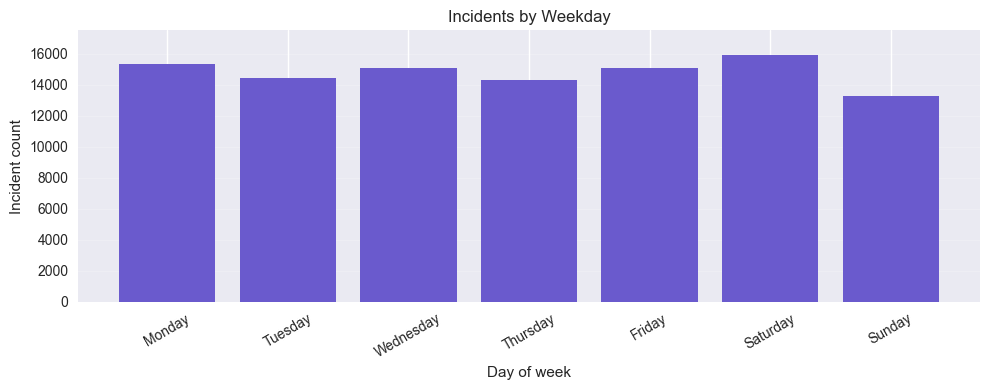

In [11]:
# Weekly incident rhythm to spot weekday bias
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = (
    df['incident_dt']
      .dropna()
      .dt.day_name()
      .value_counts()
      .reindex(weekday_order, fill_value=0)
)

peak_day = weekday_counts.idxmax()
print(f"Peak weekday: {peak_day} ({weekday_counts.max():,} incidents)")

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(weekday_counts.index, weekday_counts.values, color='slateblue')
ax.set_title('Incidents by Weekday')
ax.set_ylabel('Incident count')
ax.set_xlabel('Day of week')
ax.set_ylim(0, weekday_counts.max() * 1.1)
ax.grid(axis='y', alpha=0.2)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


C:\Users\vsita_ru1\AppData\Local\Temp\ipykernel_20416\1259565697.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly['month'] = monthly['incident_dt'].dt.to_period('M')


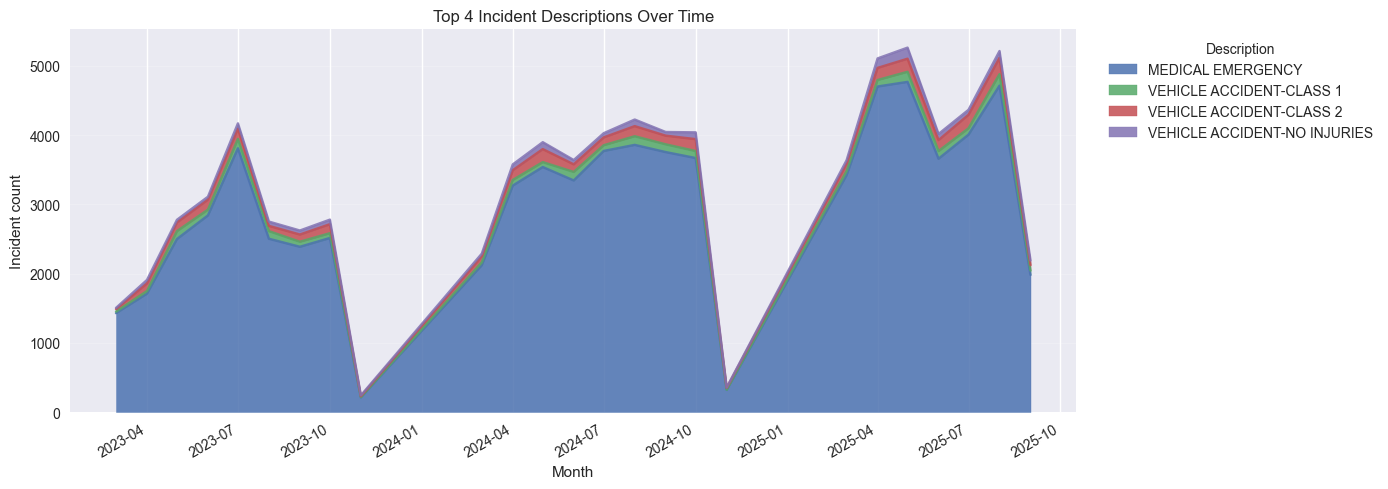

In [12]:
# Monthly trend of leading incident descriptions
monthly = df.loc[df['incident_dt'].notna()].copy()
monthly['month'] = monthly['incident_dt'].dt.to_period('M')
monthly['description_clean'] = (
    monthly['description']
      .fillna('Unknown')
      .astype(str)
      .str.strip()
      .replace('', 'Unknown')
)

TOP_DESC = 4
top_desc = monthly['description_clean'].value_counts().head(TOP_DESC).index
monthly_filtered = monthly[monthly['description_clean'].isin(top_desc)]
monthly_pivot = (
    monthly_filtered
      .groupby(['month', 'description_clean'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
monthly_pivot.index = monthly_pivot.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 5))
monthly_pivot.plot.area(ax=ax, alpha=0.85)
ax.set_title(f'Top {TOP_DESC} Incident Descriptions Over Time')
ax.set_xlabel('Month')
ax.set_ylabel('Incident count')
ax.grid(axis='y', alpha=0.2)
ax.legend(title='Description', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


Latency summary (minutes):
count   145939.00
mean        51.54
std        104.02
min          0.00
50%         32.93
75%         58.92
90%         95.71
max       8960.26
dtype: float64


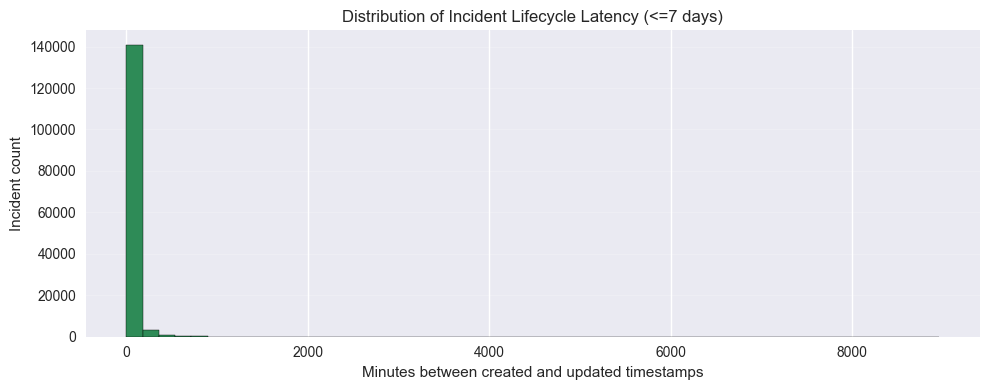

In [13]:
# Lifecycle latency between creation and last update
latency_minutes = (df['updated_at'] - df['created_at']).dt.total_seconds() / 60
latency_minutes = latency_minutes[(latency_minutes.notna()) & (latency_minutes >= 0)]

time_window_minutes = 60 * 24 * 7  # focus on latencies <= 7 days
latency_focus = latency_minutes[latency_minutes <= time_window_minutes]

print("Latency summary (minutes):")
print(latency_focus.describe(percentiles=[0.5, 0.75, 0.9]).round(2))

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(latency_focus, bins=50, color='seagreen', edgecolor='black')
ax.set_title('Distribution of Incident Lifecycle Latency (<=7 days)')
ax.set_xlabel('Minutes between created and updated timestamps')
ax.set_ylabel('Incident count')
ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


Top 5 municipalities account for 38.2% of all incidents


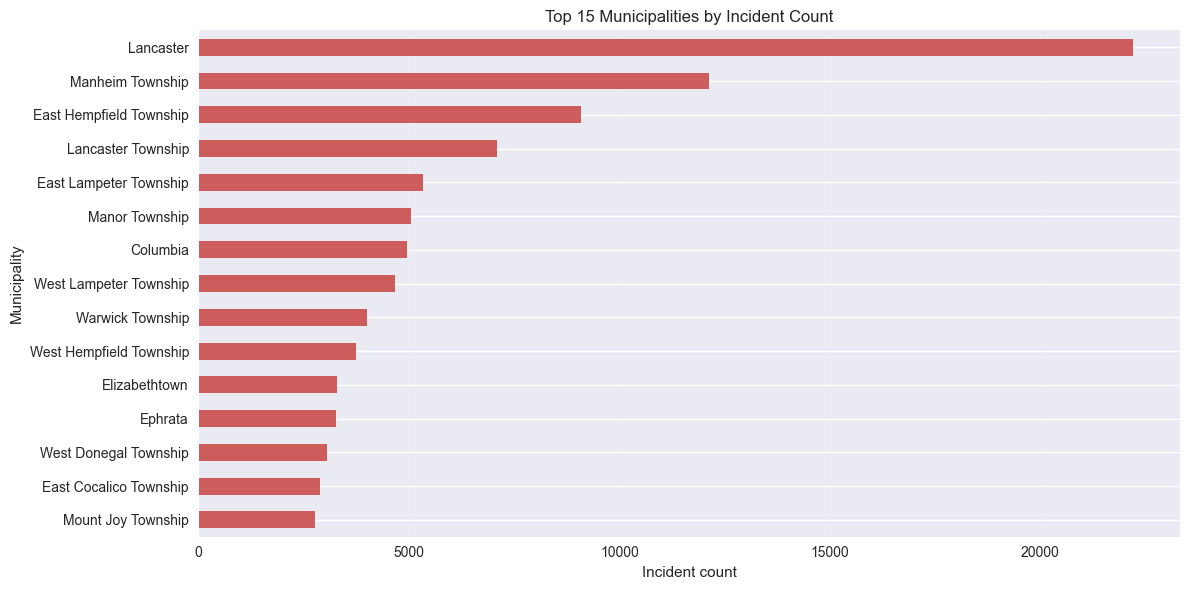

In [14]:
# Municipal hotspots to see where incidents cluster
municipality_counts = (
    df['municipality']
      .fillna('Unknown')
      .astype(str)
      .str.title()
      .replace('', 'Unknown')
      .value_counts()
)

TOP_MUNICIPALITIES = 15
share_top5 = municipality_counts.head(5).sum() / municipality_counts.sum() * 100
print(f"Top 5 municipalities account for {share_top5:.1f}% of all incidents")

fig, ax = plt.subplots(figsize=(12, 6))
(
    municipality_counts.head(TOP_MUNICIPALITIES)
        .sort_values()
        .plot(kind='barh', color='indianred', ax=ax)
)
ax.set_title(f'Top {TOP_MUNICIPALITIES} Municipalities by Incident Count')
ax.set_xlabel('Incident count')
ax.set_ylabel('Municipality')
ax.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()


Median units dispatched: 1.0
Incidents with 2+ units: 23.8%


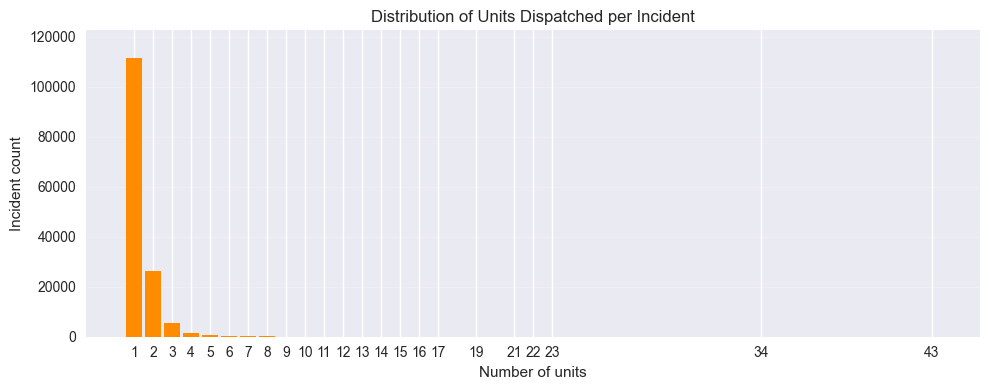

In [15]:
# Units dispatched intensity to gauge resource demand
units = pd.to_numeric(df['numberOfUnits'], errors='coerce')
units = units[units.notna() & (units > 0)]

multi_unit_share = (units >= 2).mean() * 100
print(f"Median units dispatched: {units.median():.1f}")
print(f"Incidents with 2+ units: {multi_unit_share:.1f}%")

unit_count_distribution = units.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(unit_count_distribution.index.astype(int), unit_count_distribution.values, color='darkorange')
ax.set_title('Distribution of Units Dispatched per Incident')
ax.set_xlabel('Number of units')
ax.set_ylabel('Incident count')
ax.set_xticks(unit_count_distribution.index.astype(int))
ax.set_ylim(0, unit_count_distribution.max() * 1.1)
ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


## Units vs Incident Priority and Description


Average units dispatched by priority & description (top 8 descriptions):
priority                          Priority 1  Priority 2  Priority 3
description_clean                                                   
AUTO ALARM-COMMERCIAL-INDUSTRIAL        1.00        0.00        1.82
INVESTIGATION-INSIDE                    1.00        0.00        1.90
MEDICAL EMERGENCY                       1.00        1.37        1.04
VEHICLE ACCIDENT-CLASS 1                1.00        2.03        1.85
VEHICLE ACCIDENT-CLASS 2                1.00        1.37        1.58
VEHICLE ACCIDENT-ENTRAPMENT             1.00        2.25        2.23
VEHICLE ACCIDENT-NO INJURIES            1.00        0.00        1.09
VEHICLE ACCIDENT-UNKNOWN INJURY         1.00        1.30        1.30


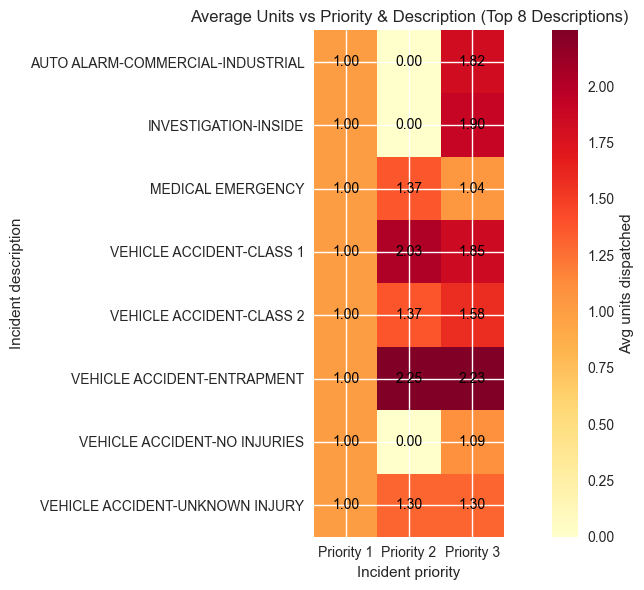

In [ ]:
priority_labels = {
    1: 'Priority 1',
    2: 'Priority 2',
    3: 'Priority 3'
}

df_priority = df[['incidentType', 'numberOfUnits', 'description']].copy()
df_priority['incidentType'] = pd.to_numeric(df_priority['incidentType'], errors='coerce')
df_priority['numberOfUnits'] = pd.to_numeric(df_priority['numberOfUnits'], errors='coerce')
df_priority = df_priority.dropna(subset=['incidentType', 'numberOfUnits'])
df_priority = df_priority[df_priority['numberOfUnits'] > 0]

df_priority['priority'] = df_priority['incidentType'].map(priority_labels).fillna(df_priority['incidentType'].astype(int).astype(str))
df_priority['description_clean'] = (
    df_priority['description']
      .fillna('Unknown')
      .astype(str)
      .str.strip()
      .replace('', 'Unknown')
)

top_desc_priority = df_priority['description_clean'].value_counts().head(8).index
subset = df_priority[df_priority['description_clean'].isin(top_desc_priority)].copy()

heatmap_data = subset.pivot_table(
    index='description_clean',
    columns='priority',
    values='numberOfUnits',
    aggfunc='mean'
).fillna(0)

print("Average units dispatched by priority & description (top 8 descriptions):")
print(heatmap_data.round(2))

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_data.values, cmap='YlOrRd')
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns)
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)
ax.set_title('Average Units vs Priority & Description (Top 8 Descriptions)')
ax.set_xlabel('Incident priority')
ax.set_ylabel('Incident description')

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        ax.text(j, i, f"{heatmap_data.iloc[i, j]:.2f}", ha='center', va='center', color='black')

fig.colorbar(cax, ax=ax, label='Avg units dispatched')
plt.tight_layout()
plt.show()


Most common incident type: 3 with 79,550 records.
Least common incident type: 1 with 6,890 records.


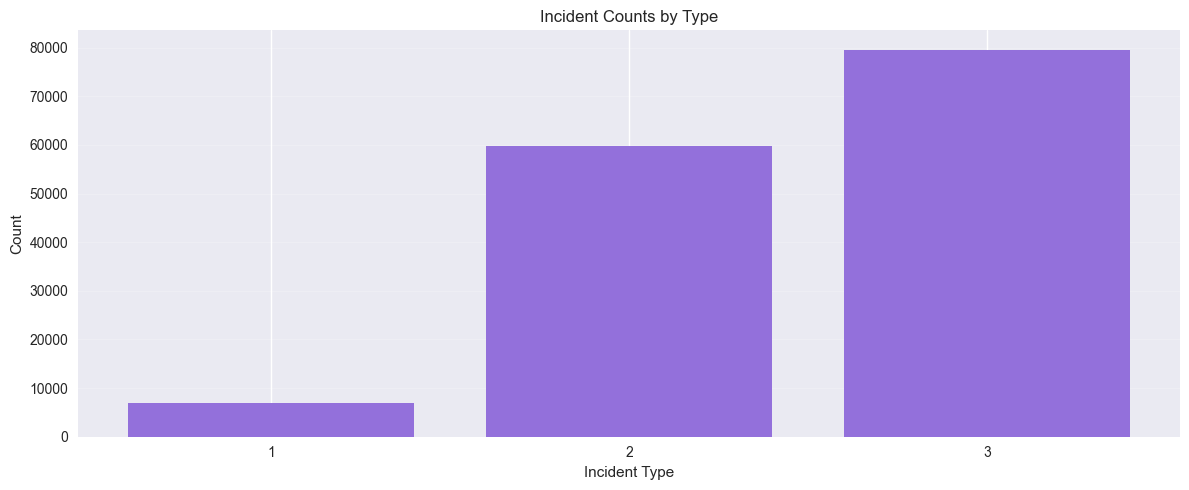

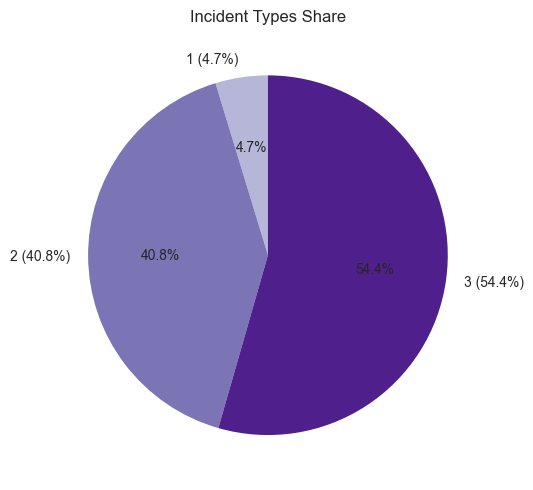

In [16]:
import numpy as np
incident_type_counts = (
    df['incidentType']
      .dropna()
      .value_counts()
      .sort_index()
)

if not incident_type_counts.empty:
    most_common_type = incident_type_counts.idxmax()
    least_common_type = incident_type_counts.idxmin()
    print(
        f"Most common incident type: {most_common_type} with {incident_type_counts[most_common_type]:,} records."
    )
    print(
        f"Least common incident type: {least_common_type} with {incident_type_counts[least_common_type]:,} records."
    )
else:
    print("No incident type data available.")

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(incident_type_counts.index.astype(str), incident_type_counts.values, color='mediumpurple')
ax.set_xlabel('Incident Type')
ax.set_ylabel('Count')
ax.set_title('Incident Counts by Type')
ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(
    incident_type_counts,
    labels=[f"{idx} ({val / incident_type_counts.sum() * 100:.1f}%)" for idx, val in incident_type_counts.items()],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Purples(np.linspace(0.4, 0.9, len(incident_type_counts)))
)
ax.set_title('Incident Types Share')
plt.tight_layout()
plt.show()


Incidents by month (all years combined):
incident_dt
March         9234
April        13291
May          14758
June         14011
July         16190
August       15453
September    11168
October       8564
November       803
Name: count, dtype: int64

Month share (%):
incident_dt
March        8.92
April       12.85
May         14.26
June        13.54
July        15.65
August      14.93
September   10.79
October      8.28
November     0.78
Name: count, dtype: float64


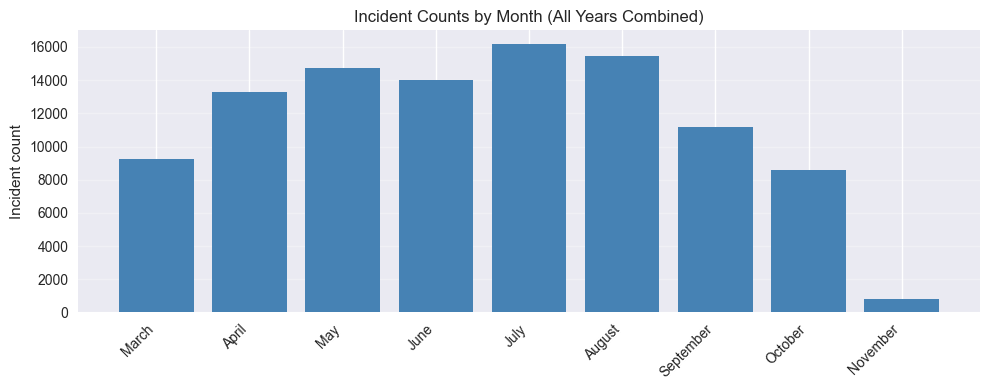

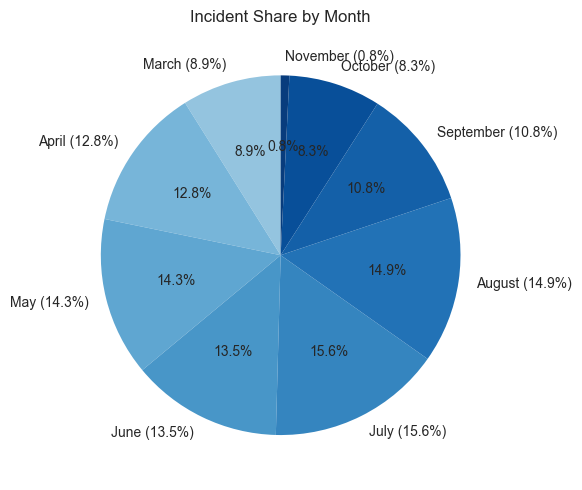

In [ ]:
incident_months = (
    df['incident_dt']
      .dropna()
      .dt.month
      .astype(int)
)

if incident_months.empty:
    print("No incidents with valid timestamps to summarize by month.")
else:
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    month_counts = incident_months.value_counts().sort_index()
    month_counts.index = month_counts.index.map(lambda m: month_names[m - 1])

    total_incidents = int(month_counts.sum())
    month_percentages = (month_counts / total_incidents) * 100

    print("Incidents by month (all years combined):")
    print(month_counts)
    print("\nMonth share (%):")
    print(month_percentages.round(2))

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(range(len(month_counts)), month_counts.values, color='steelblue')
    ax.set_xticks(range(len(month_counts)))
    ax.set_xticklabels(month_counts.index, rotation=45, ha='right')
    ax.set_title('Incident Counts by Month (All Years Combined)')
    ax.set_ylabel('Incident count')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 5))
    colors = plt.cm.Blues(np.linspace(0.4, 0.95, len(month_counts)))
    ax.pie(
        month_counts,
        labels=[f"{month} ({share:.1f}%)" for month, share in month_percentages.items()],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    ax.set_title('Incident Share by Month')
    plt.tight_layout()
    plt.show()


## Average Monthly Incidents by Year


In [17]:
incident_monthly = df.loc[df['incident_dt'].notna(), ['incident_dt']].copy()
incident_monthly['incident_dt'] = incident_monthly['incident_dt'].dt.tz_localize(None)

incident_monthly.head()



,incident_dt
0,2025-08-05 07:43:57
1,2024-10-04 23:27:31
3,2024-11-01 18:16:25
4,2024-07-22 05:52:54
5,2024-10-09 06:14:32


Average incidents per month by year:
year
2023   3065.10
2024   4214.70
2025   4217.10
dtype: float64


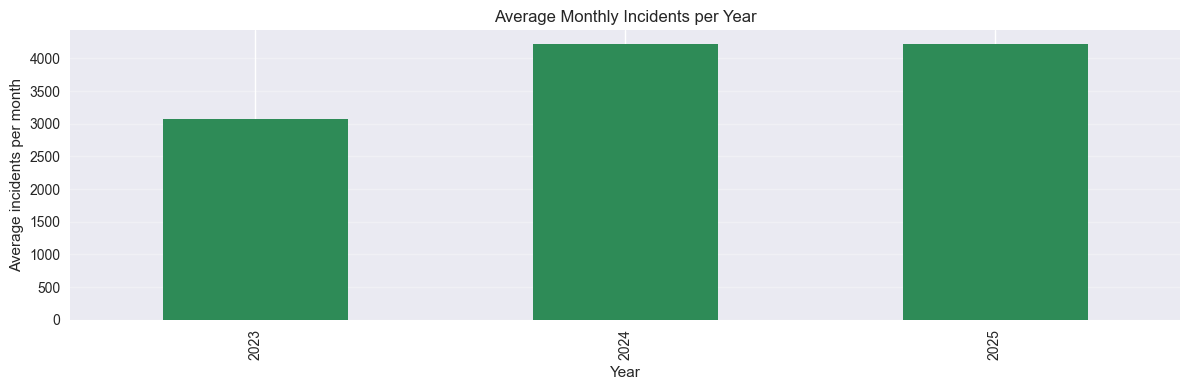

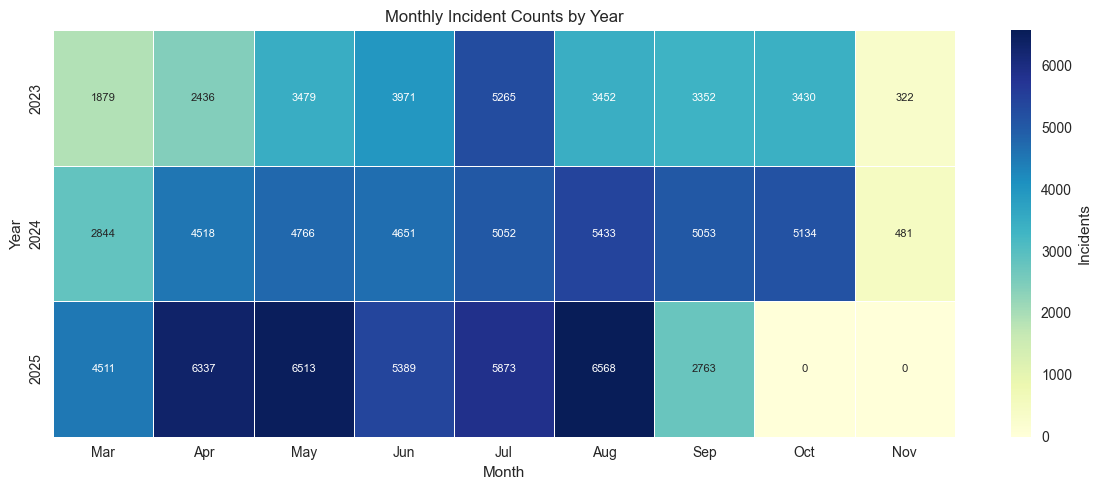

In [18]:
incident_monthly["year"] = incident_monthly["incident_dt"].dt.year.astype(int)
incident_monthly["month"] = incident_monthly["incident_dt"].dt.month.astype(int)

monthly_counts = (
    incident_monthly.groupby(["year", "month"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_counts.columns = monthly_counts.columns.map(lambda m: month_labels[m - 1])

avg_monthly_per_year = monthly_counts.mean(axis=1)

print("Average incidents per month by year:")
print(avg_monthly_per_year.round(1))

fig, ax = plt.subplots(figsize=(12, 4))
avg_monthly_per_year.plot(kind="bar", color="seagreen", ax=ax)
ax.set_title("Average Monthly Incidents per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Average incidents per month")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    monthly_counts,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Incidents"},
    annot=True,
    fmt=".0f",
    annot_kws={"size": 8},
)
ax.set_title("Monthly Incident Counts by Year")
ax.set_xlabel("Month")
ax.set_ylabel("Year")
plt.tight_layout()
plt.show()




## Top Incident Locations (80% Urban / 20% Rural)


In [ ]:
location_fields = [
    'type', 'incidentID', 'street', 'municipality', 'latitude', 'longitude'
]

locations_df = df[location_fields].copy()
locations_df['street'] = locations_df['street'].fillna('Unknown').str.strip()
locations_df['municipality'] = locations_df['municipality'].fillna('Unknown').str.strip()
locations_df['location_key'] = (
    locations_df['street'].replace('', 'Unknown') + ', ' + locations_df['municipality'].replace('', 'Unknown')
)

valid_coords = locations_df['latitude'].notna() & locations_df['longitude'].notna()
locations_df = locations_df[valid_coords]

if locations_df.empty:
    print("No incidents with valid coordinates available for location ranking.")
else:
    location_stats = (
        locations_df
        .groupby(['type', 'location_key'], as_index=False)
        .agg(
            incident_count=('incidentID', 'count'),
            latitude=('latitude', 'mean'),
            longitude=('longitude', 'mean')
        )
    )

    urban_top = location_stats[location_stats['type'] == 'urban']
    rural_top = location_stats[location_stats['type'] == 'rural']

    urban_top = urban_top.nlargest(80, 'incident_count')
    rural_top = rural_top.nlargest(20, 'incident_count')

    combined_top = (
        pd.concat([urban_top, rural_top], ignore_index=True)
          .sort_values('incident_count', ascending=False)
          .head(100)
    )

    combined_top['latitude'] = combined_top['latitude'].round(6)
    combined_top['longitude'] = combined_top['longitude'].round(6)

    print(
        f"Returned {combined_top.shape[0]} locations: "
        f"{urban_top.shape[0]} urban / {rural_top.shape[0]} rural"
    )

    display(
        combined_top[
            ['type', 'location_key', 'incident_count', 'latitude', 'longitude']
        ].reset_index(drop=True)
    )



Returned 100 locations: 80 urban / 20 rural


,type,location_key,incident_count,latitude,longitude
0,urban,"E KING ST, LANCASTER TOWNSHIP",1846,40.04,-76.31
1,urban,"LITITZ PIKE, MANHEIM TOWNSHIP",1533,40.09,-76.31
2,urban,"LINCOLN HWY E, EAST LAMPETER TOWNSHIP",1525,40.03,-76.24
3,urban,"HARRISBURG PIKE, EAST HEMPFIELD TOWNSHIP",1469,40.07,-76.35
4,urban,"E KING ST, LANCASTER",1195,40.04,-76.30
...,...,...,...,...,...
95,rural,"HORSESHOE RD, EAST LAMPETER TOWNSHIP",123,40.05,-76.22
96,rural,"MAIN ST, CAERNARVON TOWNSHIP",119,40.14,-75.94
97,rural,"KIRKWOOD PIKE, COLERAIN TOWNSHIP",112,39.85,-76.09
98,rural,"RIVER RD, MANOR TOWNSHIP",111,39.97,-76.42


## Overlapping Incidents by Time & Location

Understanding when multiple incidents hit the same area within a short window helps reveal pressure points on shared crews and infrastructure. The next cell buckets incidents into 30-minute intervals per street/municipality, flags windows with at least two calls, and summarizes which places and hours experience the heaviest overlap.


Identified 8,005 overlapping windows covering 17,123 incidents (16.5% of timestamped records)


,location_key,window_start,overlap_count
4184,"JUBILEE RD, LITTLE BRITAIN TOWNSHIP",2024-08-04 07:00:00-04:00,18
3242,"N GEORGE ST, MILLERSVILLE",2025-06-15 08:30:00-04:00,10
1554,"LANCASTER RD, PENN TOWNSHIP",2025-08-01 04:00:00-04:00,9
1949,"ROUTE 30 E, WEST HEMPFIELD TOWNSHIP",2025-05-29 02:30:00-04:00,9
28262,"PENNSYLVANIA TPKE W, CLAY TOWNSHIP",2024-04-10 22:00:00-04:00,7
1575,"OLD PHILADELPHIA PIKE, EAST LAMPETER TOWNSHIP",2025-07-24 18:30:00-04:00,6
17178,"TURNPIKE RD, WEST DONEGAL TOWNSHIP",2025-04-30 13:00:00-04:00,6
2273,"FAIRVIEW AVE, LANCASTER",2025-06-28 10:00:00-04:00,6
8384,"LAMPETER RD, WEST LAMPETER TOWNSHIP",2024-08-29 03:30:00-04:00,6
784,"READING RD, BRECKNOCK TOWNSHIP",2024-08-26 07:30:00-04:00,6


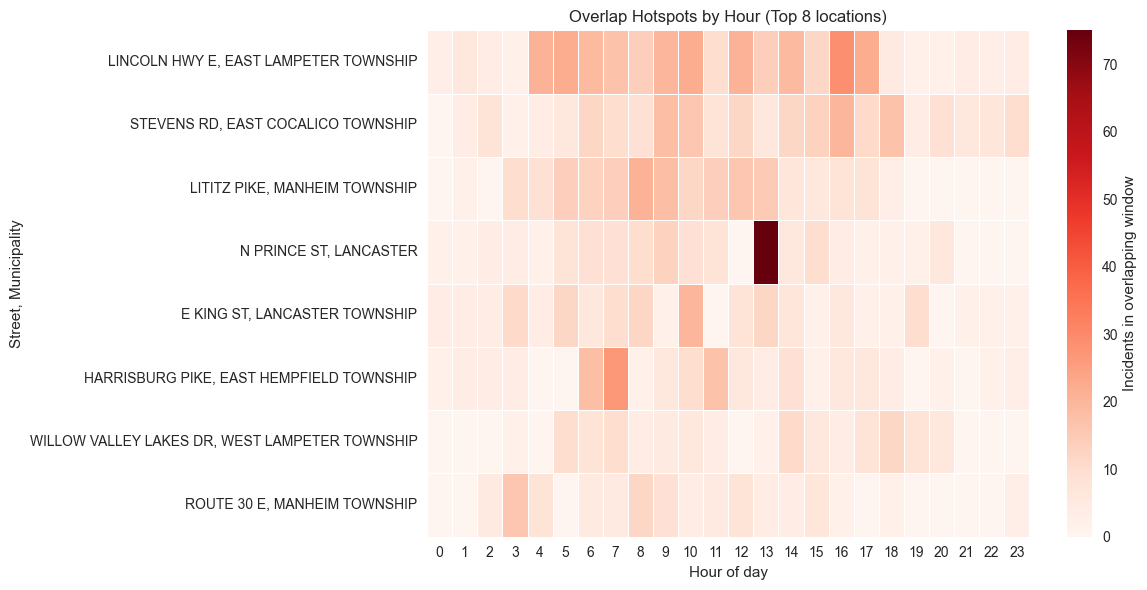

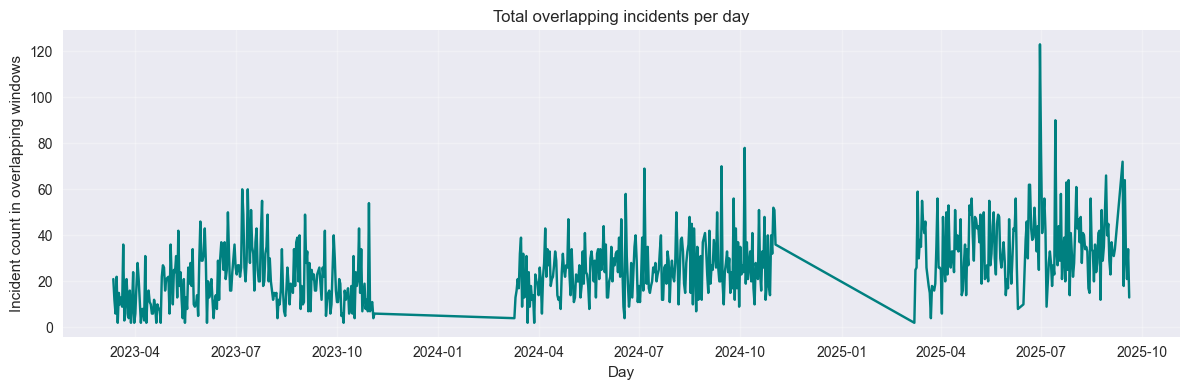

In [19]:
OVERLAP_WINDOW = '30min'

# Prep location + time buckets and flag overlapping windows (>=2 incidents).
overlap_base = (
    df[['incident_dt', 'street', 'municipality']]
      .dropna(subset=['incident_dt'])
      .copy()
)
overlap_base['location_key'] = (
    overlap_base['street'].fillna('Unknown').astype(str).str.strip().replace('', 'Unknown')
    + ', '
    + overlap_base['municipality'].fillna('Unknown').astype(str).str.strip().replace('', 'Unknown')
)
overlap_base['window_start'] = overlap_base['incident_dt'].dt.floor(OVERLAP_WINDOW)
overlap_base['overlap_size'] = overlap_base.groupby(['location_key', 'window_start'])['incident_dt'].transform('size')

overlap_incidents = overlap_base[overlap_base['overlap_size'] >= 2].copy()
overlap_windows = (
    overlap_incidents[['location_key', 'window_start', 'overlap_size']]
      .drop_duplicates()
      .rename(columns={'overlap_size': 'overlap_count'})
      .sort_values('overlap_count', ascending=False)
)

total_ts_incidents = overlap_base.shape[0]
unique_overlap_incidents = overlap_incidents.shape[0]
overlap_share = unique_overlap_incidents / total_ts_incidents * 100 if total_ts_incidents else 0

print(
    f"Identified {overlap_windows.shape[0]:,} overlapping windows "
    f"covering {unique_overlap_incidents:,} incidents "
    f"({overlap_share:.1f}% of timestamped records)"
)

if overlap_windows.empty:
    print("No overlapping incidents found within the configured window.")
else:
    top_slots = overlap_windows.head(12)
    display(top_slots)

    top_locations = (
        overlap_windows.groupby('location_key')['overlap_count']
                       .sum()
                       .nlargest(8)
                       .index
    )

    heatmap_data = (
        overlap_windows[overlap_windows['location_key'].isin(top_locations)]
            .assign(hour=lambda d: d['window_start'].dt.hour)
            .groupby(['location_key', 'hour'])['overlap_count']
            .sum()
            .unstack(fill_value=0)
            .reindex(top_locations)
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(
        heatmap_data,
        cmap='Reds',
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Incidents in overlapping window'}
    )
    ax.set_title('Overlap Hotspots by Hour (Top 8 locations)')
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Street, Municipality')
    plt.tight_layout()
    plt.show()

    hourly_overlap = (
        overlap_windows
            .assign(day=lambda d: d['window_start'].dt.date)
            .groupby('day')['overlap_count']
            .sum()
    )

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(hourly_overlap.index, hourly_overlap.values, color='teal')
    ax.set_title('Total overlapping incidents per day')
    ax.set_xlabel('Day')
    ax.set_ylabel('Incident count in overlapping windows')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



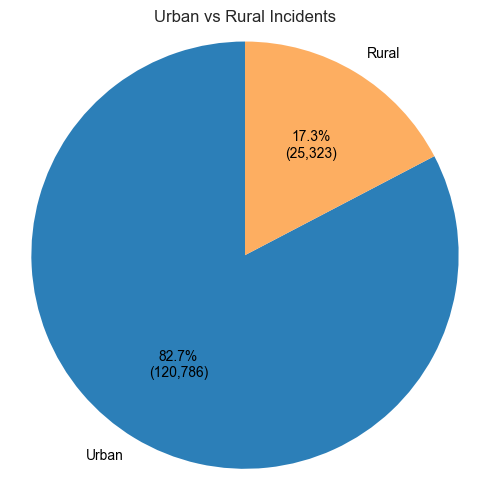